In [2]:
from tsfresh import extract_features, extract_relevant_features
import sys, os, math, random, glob, torch
from pprint import pprint # pretty print, useful for results dictionaries
import numpy as np
import pandas as pd
from sklearn import *
import warnings
# warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from utils import *

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = get_full_path("data_28") + "/"
FIGURE_DIR = get_full_path("MTL", "Figures") + "/"
# RIPE_DIR = get_full_path("ripe") + "/"

CUDA_INDEX = 0 # 0..2 for Mitra, -1 to disable (force CPU)
# CUDA_INDEX = -1

# Device Configuration
if torch.cuda.is_available() and CUDA_INDEX >= 0:
    device = torch.device(f'cuda:{CUDA_INDEX}') # MITRA has 3 CUDA GPUs available; use the third.
    torch.cuda.set_device(CUDA_INDEX)
else:
    print("Warning: Defaulting to CPU.")
    device = torch.device('cpu')

# dtype = torch.float

# device = torch.device('cpu')

In [3]:
raw = get_all_datasets() # from utils.py
master = raw

      id index             datetime     rtt
1425   0  1425  2019-01-01 18:41:53  18.381
1426   0  1426  2019-01-01 18:44:29  13.195
1427   0  1427  2019-01-01 18:44:30  15.262
1428   0  1428  2019-01-01 18:44:30  12.382
1429   0  1429  2019-01-01 18:44:31  13.951
...   ..   ...                  ...     ...
2420   0  2420  2019-01-01 22:50:14  14.515
2421   0  2421  2019-01-01 22:50:14  15.155
2422   0  2422  2019-01-01 22:50:15  22.534
2423   0  2423  2019-01-01 22:50:15  14.986
2424   0  2424  2019-01-01 22:50:16  15.284

[1000 rows x 4 columns]


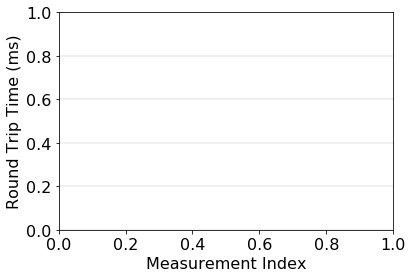

In [34]:
subset = get(raw, 8).reset_index().drop("level_0", axis=1)
subset['id'] = 0
subset = subset[1425:2425]

# %store subset
print(subset)
# del subset

visualize_rtts(subset, log_scale=False, save_figures=True, prefix="subset", useTitle=False, filetype="pdf", fontsize=16)

In [5]:
from tsfresh.feature_extraction.feature_calculators import set_property
from tsfresh.feature_extraction import feature_calculators

@set_property("fctype", "simple")
def count_nonzero(x):
    """ Returns the number of nonzero (non-loss) measurements in the time series x. """
    return np.count_nonzero(x)

@set_property("fctype", "simple")
def noise_threshold(x):
    """ Returns the noise threshold for a time series 
        by taking 1.5 * the RTT value at the 75th percentile. """
    x = x[x != 0] # remove all loss points from consideration
    return np.percentile(x, 75) * 1.5

@set_property("fctype", "simple")
def congestion_threshold(x):
    """ Returns the congestion threshold for a time series 
        by taking 1.2 * the RTT value at the 30th percentile. """
    x = x[x != 0] # remove all loss points from consideration
    return np.percentile(x, 30) * 1.2


# Add custom features to list of feature calculators:
# feature_calculators.__dict__["num_outages"] = num_outages
feature_calculators.__dict__["count_nonzero"] = count_nonzero
feature_calculators.__dict__["noise_thresh"] = noise_threshold
feature_calculators.__dict__["congestion_thresh"] = congestion_threshold


# https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html

custom = {
#     "length": None, # number of entries in each time series
    "quantile": [{"q": 0.75}], # 75% means this is the point at which it is higher value than 75% of all data points.
    "median": None,
    "mean": None,
#     "maximum": None,
#     "count_nonzero": None,
    "noise_thresh": None,
    "congestion_thresh": None
}

In [7]:
disable_progress_bar = True
# disable_progress_bar = False

""" ----- Select dataframe to extract features on ----- """
# df = master 
# df = ripe_n(100)
subset

""" Uncomment to use RIPE Atlas Data. """
# df = pd.read_csv("data/RIPE Atlas Dataset.csv")

df = subset

# Perform feature extraction with custom settings
features = extract_features(df, default_fc_parameters=custom, column_id="id", \
                            column_sort="index", column_value="rtt", \
                            disable_progressbar=disable_progress_bar).round(5)

# features.to_csv(ROOT_DIR + "/MTL/Features.csv", encoding='utf-8', header=True)
# features.to_csv(ROOT_DIR + "/MTL/RIPE Atlas Features.csv", encoding='utf-8', header=True)

features

rtt__quantile__q_0.75  rtt__median  rtt__mean  rtt__noise_threshold  \
0                 22.519       15.491   29.06964               33.7785   

   rtt__congestion_threshold  
0                   15.43668

In [32]:
subset

id     i     rtt  loss  congestion  noise
1425   0  1425  18.381     0           1      0
1426   0  1426  13.195     0           0      0
1427   0  1427  15.262     0           0      0
1428   0  1428  12.382     0           0      0
1429   0  1429  13.951     0           0      0
...   ..   ...     ...   ...         ...    ...
2420   0  2420  14.515     0           0      0
2421   0  2421  15.155     0           0      0
2422   0  2422  22.534     0           1      0
2423   0  2423  14.986     0           0      0
2424   0  2424  15.284     0           0      0

[1000 rows x 6 columns]

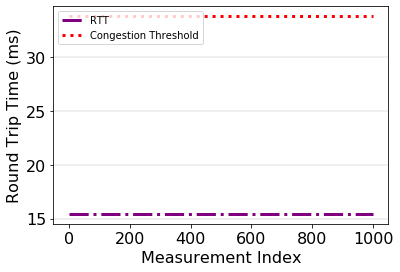

In [31]:
import random
def visualize_rtts(df, save_figures=False, log_scale=False, swells=None, noises=None, prefix="", suffix="", filetype="png", \
                   useTitle=True, bounds=(0, 0), fontsize=10, LW=1.5):
    global features
    # Get last entry in 'id' column, aka the number of datasets to loop through.
    try:
        num = df.loc[df.index[-1], 'id']
    except:
        df['id'] = df['id'].astype(int)
        num = df.loc[df.index[-1], 'id']
    
    num = 1
    i = num    
    
    current_df = df[df['id'] == i]['rtt']

    if (useTitle):
        plt.title(f"Dataset {i:02d} RTT", loc='left')
    plt.grid(axis='y', linestyle='-', linewidth=.4) # x, y, or both
    plt.xlabel('Measurement Index')
    plt.ylabel('Round Trip Time (ms)')

    trait_style = 'dashed'
    xdata = list(range(len(current_df)))

    if swells is not None:
        if type(swells) != list:
            swells = swells.to_list()
        plt.plot(xdata, [swells[i] for x in xdata], color='purple', linestyle='dashdot', linewidth=LW)
    if noises is not None:
        if type(noises) != list:
            noises = noises.to_list()
        plt.plot(xdata, [noises[i] for x in xdata], color='red', linestyle='dotted', linewidth=LW)

    if noises is not None or swells is not None:
        # add a legend
        plt.legend(['RTT', 'Congestion Threshold', 'Noise Threshold'], loc='upper left')

    plt.rc('axes', titlesize=fontsize) #fontsize of the title
    plt.rc('axes', labelsize=fontsize) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=fontsize) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=fontsize) #fontsize of the y tick labels
        
    if save_figures:
        if prefix != "" and not prefix.endswith("/"):
            prefix += "/"
        fig_dir = FIGURE_DIR + prefix
        if not os.path.exists(fig_dir): # create figure output dir if not already present
            os.makedirs(fig_dir)

        plt.savefig(fig_dir + f'dataset{i:02d}{suffix}.{filetype}', bbox_inches='tight', dpi=600)



    plt.show()
    return


noise = features['rtt__noise_threshold'][0]
cong = features['rtt__congestion_threshold'][0]
visualize_rtts(subset, log_scale=True, save_figures=True, prefix="subset", suffix="_LFs", \
               useTitle=False, filetype="pdf", fontsize=16, LW=3, \
               noises=[noise], swells=[cong])

In [42]:
noise = features['rtt__noise_threshold'][0]
cong = features['rtt__congestion_threshold'][0]

print(noise, cong)

15.43668


### Building LFs and Synthesizing new data

In [13]:
VOTE    =  1
NORMAL  =  0
ABSTAIN = -1

def label_noise(rtt, client_index):
    noise_threshold = features['rtt__noise_threshold'][client_index]
    if rtt >= noise_threshold:
        label = VOTE
    else:
        label = NORMAL
    return label

def label_outage(rtt, client_index):
    if rtt == 0:
        label = VOTE
    else:
        label = NORMAL
    return label

def label_congestion(rtt, client_index):
    cong_threshold = features['rtt__congestion_threshold'][client_index]
    noise_threshold = features['rtt__noise_threshold'][client_index]
    
    if rtt >= cong_threshold and rtt < noise_threshold:
        label = VOTE
    else:
        label = NORMAL
    return label


def generate_data(df):
    """ DF should be a labeled, original dataset. """
    global features

    newdata = pd.DataFrame(columns=["id", "i", "rtt", "loss", "congestion", "noise"])
    
    for i, row in df.iterrows():
        # print(f"Index {i}; data: \n{row['rtt']}\n")
        ID = row['id']
        
        try:
            index = row['i']
        except:
            index = row['index']
        
        # Appending original data
        rtt = row['rtt']
        l, c, n = (row['loss'], row['congestion'], row['noise']) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
        
        # Appending synthesized data -- loss
        rtt = 0
        l, c, n = (VOTE, NORMAL, NORMAL) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
        
        # Appending synthesized data -- congestion
        cong_threshold = features['rtt__congestion_threshold'][ID]
        noise_thresh = features['rtt__noise_threshold'][ID]
        rtt = np.random.randint(cong_threshold, noise_thresh)
        l, c, n = (NORMAL, VOTE, NORMAL) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
            
        # Appending synthesized data -- noise
        noise_scale = 5 # scale upper bound for noise by this. original is 4.
        gap = 500 # ensure a gap of at least XXms between synthetic congestion and noise RTT values
        noise_thresh = features['rtt__noise_threshold'][ID]
        rtt = np.random.randint(noise_thresh + gap, noise_thresh * noise_scale + gap)
        l, c, n = (NORMAL, NORMAL, VOTE) # labels
        newdata = newdata.append({'id': ID, 'i': index, 'rtt': rtt, 'loss': l, 'congestion': c, 'noise': n}, ignore_index=True)
    
    return newdata.reset_index(drop=True)

### Here, we can synthesize new data for use with Snorkel. This should only need to be done once; the data can be loaded from `~/multitaskws/MTL/data/synth.csv` rather than being generated again.  

#### This can be skipped if using the larger RIPE Atlas Datasets.

In [15]:
subset

id index             datetime     rtt
1425   0  1425  2019-01-01 18:41:53  18.381
1426   0  1426  2019-01-01 18:44:29  13.195
1427   0  1427  2019-01-01 18:44:30  15.262
1428   0  1428  2019-01-01 18:44:30  12.382
1429   0  1429  2019-01-01 18:44:31  13.951
...   ..   ...                  ...     ...
2420   0  2420  2019-01-01 22:50:14  14.515
2421   0  2421  2019-01-01 22:50:14  15.155
2422   0  2422  2019-01-01 22:50:15  22.534
2423   0  2423  2019-01-01 22:50:15  14.986
2424   0  2424  2019-01-01 22:50:16  15.284

[1000 rows x 4 columns]

In [35]:
try:
    features = extract_features(subset, default_fc_parameters=custom, column_id="id", \
                            column_sort="index", column_value="rtt", \
                            disable_progressbar=disable_progress_bar).round(5)
except:
    features = extract_features(subset, default_fc_parameters=custom, column_id="id", \
                            column_sort="i", column_value="rtt", \
                            disable_progressbar=disable_progress_bar).round(5)
df = subset
new_df = pd.DataFrame(columns=['id', 'i', 'datetime', 'rtt']) # empty dataframe to append modified DataFrames to

# print(features)

noise_threshold = features['rtt__noise_threshold'][0]
cong_threshold = features['rtt__congestion_threshold'][0]

current_df = df

# Apply labeling functions to original datasets.
current_df['loss'] = current_df['rtt'].apply(lambda x: label_outage(x, 0))
current_df['congestion'] = current_df['rtt'].apply(lambda x: label_congestion(x, 0))
current_df['noise'] = current_df['rtt'].apply(lambda x: label_noise(x, 0))
current_df.rename(columns = {'index':'i'}, inplace=True)
try:
    del current_df['datetime']
except:
    pass

# new_df = new_df.astype({"id": 'int', "i": 'int', "loss": 'int', \
#                         "congestion": 'int', "noise": 'int'}) # trim labels to ints, rather than floats

df = current_df.reset_index(drop=True)
# del df["datetime"]
# print("Done.")

#     synth.to_csv("data/synth.csv", encoding='utf-8', header=True)
#     synth.to_csv("data/synth_latest.csv", encoding='utf-8', header=True)
# synth.to_csv("data/synth_gap500.csv", encoding='utf-8', header=True)
df['i'] = df['i'] - 1425
    
print(df)

     id    i     rtt  loss  congestion  noise
0     0    0  18.381     0           1      0
1     0    1  13.195     0           0      0
2     0    2  15.262     0           0      0
3     0    3  12.382     0           0      0
4     0    4  13.951     0           0      0
..   ..  ...     ...   ...         ...    ...
995   0  995  14.515     0           0      0
996   0  996  15.155     0           0      0
997   0  997  22.534     0           1      0
998   0  998  14.986     0           0      0
999   0  999  15.284     0           0      0

[1000 rows x 6 columns]


In [37]:
# df['i'] = df['i'] - 1425
df
subset = df

# %store subset

Stored 'subset' (DataFrame)


In [38]:
tasks = ["loss", "congestion", "noise"]

# X values are the measurements (rtt), Y values are the associated labels
X_train, X_validate, X_test = {}, {}, {}
Y_train, Y_validate, Y_test = {}, {}, {}


dataframe = subset
num_entries = 1

for i in range(num_entries):
    master = get(dataframe, index=i)
    
    for task in tasks:
        splt = split_df(master)
        splt_2 = split_df(master, ct=4)
        splt_2 = splt_2[1].append(splt_2[2], ignore_index=True)
        
        X_train[task] = splt[0]['rtt'].apply(lambda x : np.array([x]))
        X_validate[task] = splt[1]['rtt'].apply(lambda x : np.array([x]))
        X_test[task] = splt_2['rtt'].apply(lambda x : np.array([x]))
        
        data_lengths.append(len(X_train[task]))
        
        Y_train[task] = splt[0][task]
        Y_validate[task] = splt[1][task]
        Y_test[task] = splt_2[task]

    rtts = master['rtt'].apply(lambda x : np.array([x])) # convert rtt's into np array of sample arrays

In [39]:
df

id    i     rtt  loss  congestion  noise
0     0    0  18.381     0           1      0
1     0    1  13.195     0           0      0
2     0    2  15.262     0           0      0
3     0    3  12.382     0           0      0
4     0    4  13.951     0           0      0
..   ..  ...     ...   ...         ...    ...
995   0  995  14.515     0           0      0
996   0  996  15.155     0           0      0
997   0  997  22.534     0           1      0
998   0  998  14.986     0           0      0
999   0  999  15.284     0           0      0

[1000 rows x 6 columns]

In [65]:
print (noise, cong)

def label_noise(rtt):
    global noise
    return 1 if rtt >= noise else 0

def label_cong(rtt):
    global cong, noise
    return 1 if rtt <= noise and rtt >= cong else 0

# df.insert(loc=len(df.cols()), "is_noise", df['rtt'].apply(label_noise, axis=1))
noises = []
congs = []
for i in df['rtt']:
    noises.append(label_noise(i))
    congs.append(label_cong(i))

try:
    df['is_noise'] = noises
    df['is_cong'] = congs
except:
    df.insert(6, "is_noise", noises)
    df.insert(7, "is_cong", congs)

df

33.7785 15.43668


id    i     rtt  loss  congestion  noise  is_noise  is_cong
0     0    0  18.381     0           1      0         0        1
1     0    1  13.195     0           0      0         0        0
2     0    2  15.262     0           0      0         0        0
3     0    3  12.382     0           0      0         0        0
4     0    4  13.951     0           0      0         0        0
..   ..  ...     ...   ...         ...    ...       ...      ...
995   0  995  14.515     0           0      0         0        0
996   0  996  15.155     0           0      0         0        0
997   0  997  22.534     0           1      0         0        1
998   0  998  14.986     0           0      0         0        0
999   0  999  15.284     0           0      0         0        0

[1000 rows x 8 columns]

In [66]:
nc = 0
cc = 0
for i in range(len(df)):
    if (df['noise'][i] != 0):
        nc += 1
    if (df['congestion'][i] != 0):
        cc += 1
        
print(f"{nc}/{len(df)} = {nc/len(df)}")
print(f"{cc}/{len(df)} = {cc/len(df)}")

140/1000 = 0.14
362/1000 = 0.362
